<a href="https://colab.research.google.com/github/ravidkrisi/Deep-Learning-Introduction/blob/main/Usage_of_Fastai_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Usage of Framework

in this notebook we will show the benefits in the usuage of predefined models from libraries like pyTorch and Fastai.

## set up data

we will start by making the connection with Kaggle and import the `titanic` data.
note: I have used the code from my previous notebook [kaggle data to colab](https://colab.research.google.com/drive/1U3Kz0flzxmoQAGN30GxwexgikXEx42t9):

In [1]:
# Install the kaggle python library
!pip install -q kaggle

# Mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")

# create directory and add the API token
! mkdir ~/.kaggle

!cp /content/drive/MyDrive/'Colab Notebooks'/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

#check if it worked
! kaggle datasets list

Mounted at /content/drive
ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/global-youtube-statistics-2023                    Global YouTube Statistics 2023                       60KB  2023-07-28 15:36:38           8245        270  1.0              
ishanshrivastava28/superstore-sales                                Superstore Sales                                      2MB  2023-08-18 19:01:11            868         38  1.0              
andrewgeorgeissac/hotel-price-data-of-cities-in-india-makemytrip   🏨Hotel Price Data of Cities in India (MakeMyTrip)    19KB  2023-08-19 06:43:04            810         29  1.0              
kumaranand05/who-su

download titanic data:

In [2]:
! kaggle competitions download titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 1.75MB/s]


unarchive the zip file:

In [3]:
! unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


we will import tabular library:

In [4]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format #used to specify that floating-point numbers should be displayed with exactly 2 decimal places
set_seed(42)

## prep the data

we'll read the train CSV file:

In [5]:
df = pd.read_csv('train.csv')

all the preperation for the data we did before when we created the model from scratch(normalization, dummy variables, missing values etc) done automaticaly when using fastai. so lets make it hard for the model and add some new features:

In [6]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==1
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master")).value_counts(dropna=False)

add_features(df)

we will use `randomSplitter` in order to split our data to validation set and training set:

In [8]:
splits = RandomSplitter(seed=42)(df)

now the process of getting the data ready for work is getting much easier:

In [9]:
 dls = TabularPandas(
    df=df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

ill try to explain each argument in the `TabularPandas` class:
- `df=` - This argument takes in a pandas DataFrame containing the tabular data you want to work with.
- `splits=` - This argument allows you to provide indices or boolean masks that define how to split your data into training, validation, and optionally test sets.
- `procs=` - This argument specifies the data preprocessing steps to be applied to the columns. It's a list of data processing functions that can include normalization, encoding categorical variables, and more. each attribute:
 - `Categorify`- Turn strings into categories.
 - `FillMissing` - fill missing values in numeric columns with the median
 - `Normalize` - normalise all numeric columns
- `cat_names=` - This argument is a list of column names that represent categorical variables in the DataFrame.
- `cont_names=` - This argument is a list of column names that represent continuous (numerical) variables in the DataFrame.
- `y_names=` - This argument is used to specify the target variable(s) you want to predict. It's a list of column names.
- `y_block=` - This argument defines how to process the target variable(s). It specifies the block type to use for the target, such as regression, classification, etc.

`.dataloaders(path=".")` - method is a function provided by the fastai library that is used to create data loaders for your tabular data.








## Train the Model

the data and the model together make up a `learner`. we will use `tabular_learner()` function to create learner object specifically designed to handle tabular data.

In [11]:
learn = tabular_learner(dls=dls, metrics=accuracy, layers=[10,10])

- `dls=` - This argument specifies the data loaders (DataLoaders object) that will provide batches of training and validation data.
- `metrics=` - A list of metrics to be computed during training and validation, such as accuracy, precision, recall, etc.
- `layers` - A list of integers representing the number of units in each layer of the model's architecture. For example, `layers=[200,100]` specifies a model with two hidden layers, having 200 and 100 units respectively.


the learner we created using fastai library has a feature that can tell us what learning rate is best to use:

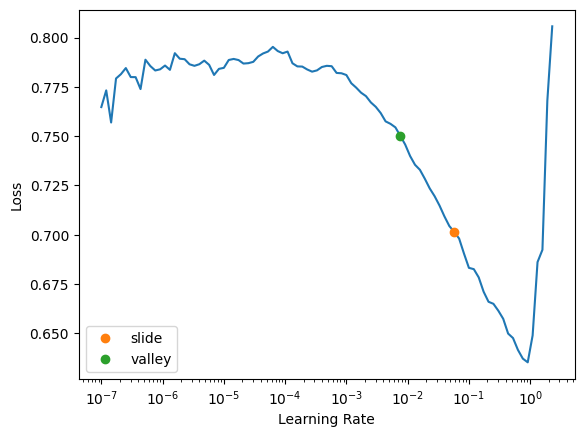

In [14]:
learn.lr_find(suggest_funcs=(slide, valley));

- `slide` - This is the area where the learning rate is gradually becoming larger but still allows the model to improve. It's the "sweet spot" where the model is learning effectively without diverging.
- `valley` - It's the point you're aiming to identify in order to choose an appropriate learning rate for training your model.


The two colored points are both reasonable choices for a learning rate. I'll pick somewhere between the two (0.03) and train for a few epochs:

In [15]:
learn.fit(n_epoch=16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.603772,0.602265,0.595506,00:00
1,0.527055,0.454676,0.808989,00:00
2,0.491568,0.428678,0.797753,00:00
3,0.466636,0.429151,0.814607,00:00
4,0.453607,0.447235,0.780899,00:00
5,0.443266,0.420910,0.808989,00:00
6,0.430229,0.433128,0.820225,00:00
7,0.421441,0.413994,0.797753,00:00
8,0.415577,0.433877,0.820225,00:00
9,0.410691,0.442883,0.825843,00:00


as we can see our accuracy scored the same results like the model we created form scratch. as we said before the data is small and this problem can be solved with simple linear model.

## Submit to Kaggle

we can submit to Kaggle using fastai functions.
To submit to Kaggle, we'll need to read in the test set, and do the same feature engineering we did for the training set:

In [16]:
tst_df = pd.read_csv('test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

But we don't need to manually specify any of the processing steps necessary to get the data ready for modeling, since that's all saved in the learner. To specify we want to apply the same steps to a new dataset, use the `test_dl()` method:

In [17]:
tst_dl = learn.dls.test_dl(tst_df)

Now we can use `get_preds` to get the predictions for the test set:

In [38]:
preds,targets = learn.get_preds(dl=tst_dl)
preds

tensor([[0.9062, 0.0938],
        [0.4515, 0.5485],
        [0.8827, 0.1173],
        [0.8582, 0.1418],
        [0.3468, 0.6532],
        [0.7895, 0.2105],
        [0.2950, 0.7050],
        [0.8912, 0.1088],
        [0.2623, 0.7377],
        [0.8527, 0.1473],
        [0.9114, 0.0886],
        [0.8002, 0.1998],
        [0.0522, 0.9478],
        [0.8983, 0.1017],
        [0.0122, 0.9878],
        [0.0368, 0.9632],
        [0.8169, 0.1831],
        [0.7280, 0.2720],
        [0.4663, 0.5337],
        [0.2626, 0.7374],
        [0.7559, 0.2441],
        [0.4945, 0.5055],
        [0.0868, 0.9132],
        [0.6649, 0.3351],
        [0.1670, 0.8330],
        [0.9757, 0.0243],
        [0.0643, 0.9357],
        [0.7403, 0.2597],
        [0.5988, 0.4012],
        [0.6677, 0.3323],
        [0.9299, 0.0701],
        [0.8989, 0.1011],
        [0.6692, 0.3308],
        [0.5659, 0.4341],
        [0.6838, 0.3162],
        [0.7067, 0.2933],
        [0.4571, 0.5429],
        [0.3870, 0.6130],
        [0.8

the return values from `.get_preds()` are:
- `preds` - This is a tensor containing the predicted outputs from the model. The shape of this tensor depends on the type of problem you're working on.
- `targets` - This is a tensor containing the target values associated with the inputs used to generate the predictions.

Finally, let's create a submission CSV just like we did in the previous notebook...

In [29]:
tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

check our CSV file

In [30]:
!head sub.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


## Ensembling

we can create five separate models, each trained from different random starting points, and average them, this approach called Ensembling.

In [31]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

now we run this five times and collect the results to a list:

In [35]:
learns = [ensemble() for _ in range(5)]

now we stack the predictions together and take the average prediction:

In [36]:
ens_preds = torch.stack(learns).mean(0)
ens_preds

tensor([[0.9163, 0.0837],
        [0.5153, 0.4847],
        [0.9342, 0.0658],
        [0.8925, 0.1075],
        [0.4890, 0.5110],
        [0.8660, 0.1340],
        [0.4284, 0.5716],
        [0.8542, 0.1458],
        [0.3340, 0.6660],
        [0.8949, 0.1051],
        [0.9268, 0.0732],
        [0.8680, 0.1320],
        [0.0290, 0.9710],
        [0.8369, 0.1631],
        [0.0180, 0.9820],
        [0.0311, 0.9689],
        [0.9068, 0.0932],
        [0.7559, 0.2441],
        [0.5308, 0.4692],
        [0.5366, 0.4634],
        [0.7516, 0.2484],
        [0.5120, 0.4880],
        [0.0847, 0.9153],
        [0.6607, 0.3393],
        [0.1731, 0.8269],
        [0.9626, 0.0374],
        [0.0255, 0.9745],
        [0.7756, 0.2244],
        [0.7827, 0.2173],
        [0.8782, 0.1218],
        [0.9290, 0.0710],
        [0.9145, 0.0855],
        [0.6232, 0.3768],
        [0.6061, 0.3939],
        [0.6763, 0.3237],
        [0.7260, 0.2740],
        [0.6178, 0.3822],
        [0.5555, 0.4445],
        [0.8